In [1]:
# Nightlights(processed by DenseNet121) + Doc2Vec

import pandas as pd
import tensorflow as tf
from pathlib import Path
import sys
import numpy as np
from scipy.misc import imshow, imresize
import os
import pickle
import pdb
import random
import glob

import tensorflow as tf
import numpy as np
from pprint import pprint
import keras
from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, Input, Concatenate,concatenate
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
from keras.applications.densenet import DenseNet121
from sklearn.preprocessing import normalize

Using TensorFlow backend.


In [27]:

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import collections

In [4]:
result_dir = '/atlas/u/esheehan/GUF_dataset/output/'
tfrecord_dir = '/atlas/u/chenlin/wikipedia_images/Poverty_prediction/Processed_data/'

files = ['2015-17_ghana', '2009-11_nigeria']
tfrecord_train = tfrecord_dir + files[0]+'/'
tfrecord_test = tfrecord_dir + files[1]+'/'

print("Train path:", tfrecord_train)
print("Test path:", tfrecord_test)

Train path: /atlas/u/chenlin/wikipedia_images/Poverty_prediction/Processed_data/2015-17_ghana/
Test path: /atlas/u/chenlin/wikipedia_images/Poverty_prediction/Processed_data/2009-11_nigeria/


In [7]:
def concatenate_doc2vec(i, num):
    embeddings = []
    for index, article in enumerate(i[6]):
        #pdb.set_trace()
        embeddings += list(article[4]) + [article[0]]
        if index == num - 1:
            break
    return embeddings


def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

band_names = ['BLUE', 'GREEN', 'RED']
# x label

## Not used in new version
def _parse_function(example_proto):
    features = {
        band_name : tf.FixedLenFeature(shape=[255**2], dtype=tf.float32) for band_name in ['LAT','LON','RED','GREEN','BLUE','NIGHTLIGHTS']
    }
    features['wealthpooled'] = tf.FixedLenFeature(shape=[1], dtype=tf.float32)
    parsed_features = tf.parse_single_example(example_proto, features)
    for band_name in band_names:
        parsed_features[band_name] = tf.cast(parsed_features[band_name], tf.float64)
    parsed_features['wealthpooled'] = tf.cast(parsed_features['wealthpooled'], tf.float64)
    parsed_features['LAT'] = tf.cast(parsed_features['LAT'], tf.float64)
    parsed_features['LON'] = tf.cast(parsed_features['LON'], tf.float64)
    return parsed_features 



def load_data(train_dir, test_dir):
    tfrecord_train = []
    tfrecord_test = []
    options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
     
    #load data
    for name_index in range(len(glob.glob(train_dir+'*.gz'))):
        tfrecord_train.append(train_dir+str(name_index)+'.tfrecord.gz')
    for name_index in range(len(glob.glob(test_dir+'*.gz'))):
        tfrecord_test.append(test_dir+str(name_index)+'.tfrecord.gz')

    
    X_train,Y_train, X_test, Y_test = [], [], [], []
    with open(train_dir +'doc2vec_info.txt','rb') as f:
        train_doc2vec = pickle.load(f)
        
    with open(test_dir +'doc2vec_info.txt','rb') as f:
        test_doc2vec = pickle.load(f)
    
    for train_current in range(len(tfrecord_train)):
        # file name, embeddings
        if train_doc2vec[train_current][0] == None: # LAT,LON=NONE in tfrecord
            continue
        
        X_train.append([tfrecord_train[train_current],np.array(concatenate_doc2vec(train_doc2vec[train_current][0],10))])
        iterator = tf.python_io.tf_record_iterator(tfrecord_train[train_current], options=options)
        record_str = next(iterator)
        ex = tf.train.Example.FromString(record_str) 
        feature_map = ex.features.feature 
        Y_train.append(feature_map['wealthpooled'].float_list.value[0])
        
    for test_current in range(len(tfrecord_test)):
        # file name, embeddings
        if test_doc2vec[test_current][0] == None: # LAT, LON=NONE in tfrecord
            continue
        
        X_test.append([tfrecord_test[test_current], np.array(concatenate_doc2vec(test_doc2vec[test_current][0],10))])
        iterator = tf.python_io.tf_record_iterator(tfrecord_test[test_current], options=options)
       
        record_str = next(iterator)
        ex = tf.train.Example.FromString(record_str) 
        
        feature_map = ex.features.feature 
        Y_test.append(feature_map['wealthpooled'].float_list.value[0])
        
    print("Data Loaded") 
    return X_train, Y_train,X_test, Y_test

In [23]:
# X_train, Y_train,X_test, Y_test = load_data(tfrecord_train, tfrecord_test) 

In [24]:
def find_embeding(doc2vecs, lat,lon):
    closest = float('inf')
    vec = None
    for i in range(len(doc2vecs)):
        if len(doc2vecs[i])>=5:
            temp = (lat-doc2vecs[i][0][0])**2 + (lon-doc2vecs[i][0][1])**2
            if temp<=closest:
                closest = temp
                vec = doc2vecs[i]
    if vec:
        return vec
    return None


# Images are 224x224 numpy arrays 
def load_model():
    np.random.seed(1234)
    model1 = Input(shape=(224, 224, 3))
    
    densenet = DenseNet121(weights='imagenet')
    densenet.layers.pop()
    x = densenet(model1)
    x = Dense(512, kernel_initializer='normal', activation='tanh')(x)
    x = Dense(256)(x)
    
    model2 = Input(shape=(3010,))
    #
    x2 = Dense(512, kernel_initializer='normal', activation='sigmoid')(model2)
    x2 = Dense(256, kernel_initializer='normal', activation='tanh')(x2)
    merge = concatenate([x, x2])
    #
    
    merge = Dense(512, input_shape=(2,256), kernel_initializer='normal', activation='relu')(merge)
    merge = Dense(256, kernel_initializer='normal', activation='sigmoid')(merge)
    #merge = Dense(256, kernel_initializer='normal', activation='relu')(merge)
    merge = Dense(32, kernel_initializer='normal', activation='tanh')(merge)
    #merge = Dense(32, kernel_initializer='normal', activation='relu')(merge)
    merge = Dense(1, kernel_initializer='normal', kernel_regularizer=regularizers.l2(1e-7))(merge)
    model = Model(inputs= [model1,model2], outputs=merge)
    adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=adam)#, metrics=[coeff_determination, 'mae'])
    print(model.summary())
    return model


In [25]:
def run_model(tfrecord_train, tfrecord_test):
    EPOCH = 15
    BATCH_SIZE = 32
    options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
    X_train, Y_train,X_test, Y_test = load_data(tfrecord_train, tfrecord_test) 
    
    comb_train = list(zip(X_train, Y_train))
    random.shuffle(comb_train)
    X_train,Y_train = zip(*comb_train)
    comb_test = list(zip(X_test, Y_test))
    random.shuffle(comb_test)
    X_test,Y_test = zip(*comb_test)
    
    #X_test = list(X_test)
    #random.shuffle(X_test)
    
    X_train, Y_train, X_test, Y_test = list(X_train),list(Y_train), list(X_test), list(Y_test)
    
    model = load_model()
    history = collections.defaultdict(float)
    for epoch in range(EPOCH):
        print("Starting epoch: {}".format(epoch))
        # iterate through all the training examples

        for train_iterator in range(int(len(X_train)/BATCH_SIZE)):
            images = np.zeros((BATCH_SIZE,224,224,3))
            embeddings = np.zeros((BATCH_SIZE, 3010))
            for item in range(BATCH_SIZE):
                
                embeddings[item] = X_train[train_iterator*BATCH_SIZE+item][1]
                iterator = tf.python_io.tf_record_iterator(X_train[train_iterator*BATCH_SIZE+item][0], options=options)
                record_str = next(iterator)
                ex = tf.train.Example.FromString(record_str)  # parse into an actual Example message
                feature_map = ex.features.feature  # get the mapping from feature name strings to Feature

                n = feature_map['NIGHTLIGHTS'].float_list.value
                n = np.array(n).reshape(224,-1)
                images[item] = np.stack([n,n,n], axis=-1) 
                plt.imshow(images[item])
            
                #pdb.set_trace() 
            Index = Y_train[train_iterator*BATCH_SIZE: (train_iterator+1)*BATCH_SIZE]  
            model_loss = model.train_on_batch([images,embeddings], Index)
            prediction = model.predict([images,embeddings], batch_size=BATCH_SIZE)
            trainMSE = mean_squared_error(np.asarray(Index),np.asarray(prediction))
            trainR2 = r2_score(np.asarray(Index), np.asarray(prediction))         
            history[(epoch, 'loss')] += model_loss
                        
        history[(epoch, 'loss')] /= int(len(X_train)/BATCH_SIZE)
       
        #print(history[(epoch, 'loss')])
        print("Epoch ", epoch)
        print("Train Loss", history[(epoch, 'loss')])
        
           
        ### VALIDATION 
        print("Testing function")
        all_labels = []
        all_preds = [] 
        for test_iterator in range(int(len(X_test)/BATCH_SIZE)):
            images_val = np.zeros((BATCH_SIZE,224,224,3))
            embeddings_val = np.zeros((BATCH_SIZE, 3010))
            for item in range(BATCH_SIZE):
                embeddings_val[item] = X_test[test_iterator*BATCH_SIZE+item][1]
                iterator = tf.python_io.tf_record_iterator(X_test[test_iterator*BATCH_SIZE+item][0], options=options)
                record_str = next(iterator)
                ex = tf.train.Example.FromString(record_str)  # parse into an actual Example message
                feature_map = ex.features.feature  # get the mapping from feature name strings to Feature

                n = feature_map['NIGHTLIGHTS'].float_list.value
                n = np.array(n).reshape(224,-1)
                images_val[item] = np.stack([n,n,n], axis=-1) 
            
            Index_val = Y_test[test_iterator*BATCH_SIZE: (test_iterator+1)*BATCH_SIZE]                  
            prediction_val = model.predict([images_val,embeddings_val], batch_size=BATCH_SIZE)
            all_labels.append(Index_val)
            all_preds.append(np.asarray(prediction_val))
           
        valR2 =  r2_score(np.concatenate(all_labels, axis=0).reshape(-1), np.concatenate(all_preds, axis=0).reshape(-1))
        (rho,p_value) = stats.spearmanr(np.concatenate(all_labels, axis=0).reshape(-1), np.concatenate(all_preds, axis=0).reshape(-1))
        length = len(np.concatenate(all_labels, axis=0))
        (r_pearson,p_value_pearson) = stats.pearsonr(np.concatenate(all_labels, axis=0).reshape(-1), np.concatenate(all_preds, axis=0).reshape(-1))
        valL2Loss = (1/length)*np.sum(np.square(np.concatenate(all_labels, axis=0).reshape(-1)-np.concatenate(all_preds, axis=0).reshape(-1)))

        print("R2_score: ", valR2) 
        print("Spearmans rho: {}, p_value: {}".format(rho, p_value))
        print('Pearson\'r: {}, p_value: {}'.format(r_pearson,p_value_pearson))         
        print('L2 loss:{}'.format(valL2Loss))

        history[(epoch, "prediction")] = np.concatenate(all_preds, axis=0).reshape(-1)
        history[(epoch, "ground_truth")] = np.concatenate(all_labels, axis=0).reshape(-1)
        history[(epoch, "val_loss")] = valL2Loss
        history[(epoch, "val_r2")] = valR2
        history[(epoch, "val_spearman")] = (rho, p_value)
        history[(epoch, "val_pearson")] = (r_pearson,p_value_pearson)
    return history              

Running model
Train on: 2015-17_ghana, Test on : 2009-11_nigeria
Data Loaded
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
densenet121 (Model)             (None, 1000)         7037504     input_4[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 3010)         0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 512)          512512      densenet121[1][0]                
________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

KeyboardInterrupt: 

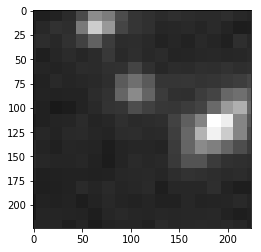

In [28]:
if __name__ == "__main__":
    results = {}
    result_dir = '/atlas/u/esheehan/GUF_dataset/output/'
    tfrecord_dir = '/atlas/u/chenlin/wikipedia_images/Poverty_prediction/Processed_data/'
    files = []
#    with open(result_dir+'Doc2VecModel_Nightlight-new1.txt', 'rb') as f:
#        results = pickle.load(f)
    
    #for tf_file in os.listdir(tfrecord_dir):
    #    files.append(tf_file)
#    files = ['2009-11_nigeria', '2012-14_ghana_','2009-11_malawi', '2009-11_uganda','2009-11_tanzania'] #,'2012-14_uganda', '2015-17_ghana', '2015-17_nigeria','2015-17_tanzania']

    files = ['2015-17_ghana', '2009-11_nigeria']

    for i in range(len(files)):
        for j in range(i+1,len(files),1):
            tfrecord_train = tfrecord_dir + files[i]+'/'
            tfrecord_test = tfrecord_dir + files[j]+'/'
            print("Running model\nTrain on: {}, Test on : {}".format(files[i],files[j]))
            file_name = result_dir + 'train_'+files[i]+'_' +'test_'+files[j]+'.txt'
            if file_name not in results.keys():  
                results[file_name] = run_model(tfrecord_train,tfrecord_test)
  
                with open(result_dir+'Doc2VecModel_Nightlight-new1.txt','wb') as f:
                    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
            
            tfrecord_train = tfrecord_dir + files[j]+'/'
            tfrecord_test = tfrecord_dir + files[i]+'/'
            print("Running model\nTrain on: {}, Test on : {}".format(files[j],files[i]))
            file_name = result_dir + 'train_'+files[j]+'_' +'test_'+files[i]+'.txt'
            if file_name not in results.keys():
                results[file_name] = run_model(tfrecord_train,tfrecord_test)
            
                with open(result_dir+'Doc2VecModel_Nightlight-new1.txt','wb') as f:
                    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    with open(result_dir+'Doc2VecModel_Nightlight-new1.txt','wb') as f:
        pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
        